<a href="https://colab.research.google.com/github/nayankote/Neural-Style-Transfer/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import imageio
import pprint
from tensorflow.python.framework import ops
from tensorflow import keras
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
class config:
    
    image_width = 800
    image_height = 600
    color_channels = 3
    noise_ratio = 0.6
    means = np.array([123.68, 116.779, 103.999]).reshape((1,1,1,3)) #this is the mean RGB value in the imagenet data
    #surprisingly(or not) a mud greyish brown is the most common color
    root_path = 'gdrive/My Drive/Colab Notebooks/Neural Style Transfer'
    model = "/content/gdrive/My Drive/Colab Notebooks/Neural Style Transfer/imagenet-vgg-verydeep-19.mat"
    style_image = '/content/gdrive/My Drive/Colab Notebooks/Neural Style Transfer/monet.jpg'
    content_image = '/content/gdrive/My Drive/Colab Notebooks/Neural Style Transfer/louvre.jpg'
    output_dir = 'content/gdrive/"My Drive"/Colab Notebooks/Neural Style Transfer/'
    style_layers = [    
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)] #try changing these

In [0]:
def load_vgg_model():
    
    model_load = scipy.io.loadmat("/content/gdrive/My Drive/Colab Notebooks/Neural Style Transfer/imagenet-vgg-verydeep-19.mat")
    model_layers = model_load['layers']
    
    def _weights(layer, expected_layer_name):
        wb = model_layers[0][layer][0][0][2] #check what model_layers are 
        W = wb[0][0]
        b = wb[0][1]
        layer_name = model_layers[0][layer][0][0][0]
        assert layer_name == expected_layer_name
        return W,b
        
    def _conv2d(prev_layer, layer, layer_name):
        W,b = _weights(layer,layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filters = W, strides = [1,1,1,1], padding = 'SAME') + b
    
    def _conv2d_relu(prev_layer, layer, layer_name):
        return tf.nn.relu(_conv2d(prev_layer, layer, layer_name))
    
    def _pool(prev_layer, pooltype = 'avg'):
        if pooltype == 'avg':
            return tf.nn.avg_pool(prev_layer, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
        else : 
            return tf.nn.max_pool(prev_layer, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    #constructing the model (copied from coursera)
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, config.image_height, config.image_width, config.color_channels)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _pool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _pool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _pool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _pool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _pool(graph['conv5_4'])
    
    return graph

In [0]:
def generate_noise_image(content_image, noise_ratio = config.noise_ratio):
    
    noise_image = np.random.uniform(-20, 20, (1, config.image_height, config.image_width, config.color_channels)).astype('float32') 
    #check what happens with np.random.randn and changing +- 20
    
    input_image = noise_ratio*noise_image + (1-noise_ratio)*content_image 
    #check changing ratio and try random init
    
    return input_image 

In [0]:
def reshape_and_normalize_image(image):
    
    image = np.reshape(image, ((1,) + image.shape)) #required input shape for vgg19

    image = image - config.means
    
    return image

In [0]:
def save_image(path, image):
    
    image = image + config.means
    
    image = np.clip(image[0],0,255).astype('uint8') 
    #changes values >255 (or <0) to 255 (or 0)
    
    imageio.imwrite(path, image)

In [0]:
#cost computation
def content_cost(a_C,a_G):
    (m, n_H, n_W, n_C) = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(tf.transpose(a_C, perm = [0,3,1,2]), shape = [m,-1,n_C])
    a_G_unrolled = tf.reshape(tf.transpose(a_G, perm = [0,3,1,2]), shape = [m,-1,n_C])
    
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C,a_G)))/(4*n_H*n_W*n_C)
    
    return J_content

def gram_matrix(img):
    
    return tf.matmul(img,tf.transpose(img))

def style_cost_layer(a_S,a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S_unrolled = tf.reshape(tf.transpose(a_S, perm = [0,3,1,2]), shape = [n_C,-1])
    a_G_unrolled = tf.reshape(tf.transpose(a_G, perm = [0,3,1,2]), shape = [n_C,-1])
    
    gram_a_S = gram_matrix(a_S_unrolled)
    gram_a_G = gram_matrix(a_G_unrolled)
    
    J_style_layer = tf.reduce_sum(tf.reduce_sum(tf.square(tf.subtract(gram_a_S, gram_a_G))))/((2*n_H*n_W*n_C)**2)
    
    return J_style_layer

def total_style_cost(model, layers = config.style_layers):
    
    J_style = 0
    
    for layer_name, coeff in layers:
        out = model[layer_name]
        
        a_S = sess.run(out)
        
        a_G = out
        
        J_style += coeff*style_cost_layer(a_S,a_G)
    
    return J_style

def total_cost(J_content, J_style, alpha = 10, beta = 40): #mess around with the weights
    
        return alpha*J_content + beta*J_style

In [0]:
# Reset the graph
ops.reset_default_graph()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


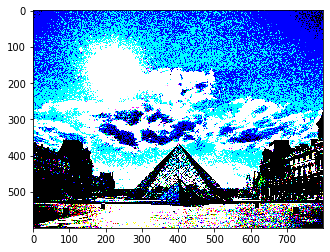

In [10]:
#loading images 
content_image = imageio.imread(config.content_image)
content_image = reshape_and_normalize_image(content_image)
style_image = imageio.imread(config.style_image)
style_image = reshape_and_normalize_image(style_image)
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [0]:
# loading model 
model = load_vgg_model()
var_list_fn = lambda: model.trainable_weights

In [12]:
from tensorflow.python.framework.ops import disable_eager_execution
with tf.compat.v1.Session() as sess : 
    sess.run(model['input'].assign(content_image))
    out = model['conv4_2']
    a_C = sess.run(out)
    a_G = out
    J_content = content_cost(a_C,a_G)
    
    sess.run(model['input'].assign(style_image))
    J_style = total_style_cost(model,config.style_layers)
    
    J = total_cost(J_content,J_style,10,40)
    
    optimizer = tf.compat.v1.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(J)
    
    def model_nn(sess, input_image, num_iterations = 300):
        sess.run(tf.compat.v1.global_variables_initializer())
        
        sess.run(model['input'].assign(input_image))
        
        for i in range(num_iterations):
            sess.run(train_step)
            
            generated_image = sess.run(model['input'])
            
            if i%50 == 0 :
                Jt,Jc,Js = sess.run([J, J_content, J_style])
                print("Iteration "+str(i) +":")
                print("total cost = "+str(Jt))
                print("content cost = "+str(Jc))
                print("style cost = "+str(Js))
                save_image("/content/gdrive/My Drive/Colab Notebooks/Neural Style Transfer/"+str(i) +".png",generated_image)
            
        save_image('/content/gdrive/My Drive/Colab Notebooks/Neural Style Transfer/generated_image_final.jpg',generated_image)
        
        return generated_image
    
    model_nn(sess, generated_image)

Iteration 0:
total cost = 4283599000.0
content cost = 7011.02
style cost = 107088220.0
Iteration 50:
total cost = 349075680.0
content cost = 15981.603
style cost = 8722897.0
Iteration 100:
total cost = 166063520.0
content cost = 16911.467
style cost = 4147360.0
Iteration 150:
total cost = 106391930.0
content cost = 17252.717
style cost = 2655485.0
Iteration 200:
total cost = 75869540.0
content cost = 17421.395
style cost = 1892383.0
Iteration 250:
total cost = 57698212.0
content cost = 17552.516
style cost = 1438067.2
